In [5]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Set
import requests
import warnings
warnings.filterwarnings("ignore")

In [6]:
# !pip install matplotlib seaborn

In [7]:
# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [10]:
class NgramLanguageModel:
    """
    Complete N-gram language model with multiple smoothing techniques.
    Implements everything from scratch for educational purposes.
    """
    
    def __init__(self, n: int = 2, smoothing: str = 'laplace'):
        """
        Initialize the n-gram model.
        
        Args:
            n: Size of n-grams (2 for bigrams, 3 for trigrams)
            smoothing: Type of smoothing ('laplace', 'add_alpha', 'good_turing', 'kneser_ney')
        """
        self.n = n
        self.smoothing = smoothing
        self.vocab = set()
        self.ngram_counts = defaultdict(int)
        self.context_counts = defaultdict(int)
        self.vocabulary_size = 0
        
        # For Good-Turing smoothing
        self.frequency_of_frequencies = defaultdict(int)
        
        # For Kneser-Ney smoothing
        self.continuation_counts = defaultdict(int)
        self.unique_contexts = defaultdict(set)
        
        # Parameters
        self.alpha = 0.5  # for add-alpha smoothing
        self.discount = 0.75  # for Kneser-Ney smoothing
        
    def preprocess_text(self, text: str) -> List[str]:
        """
        Preprocess text: tokenize, lowercase, handle punctuation.
        """
        # Convert to lowercase and split on whitespace/punctuation
        text = re.sub(r'[^\w\s]', ' ', text.lower())
        tokens = text.split()
        
        # Add sentence boundary markers
        tokens = ['<s>'] * (self.n - 1) + tokens + ['</s>']
        return tokens
    
    def extract_ngrams(self, tokens: List[str]) -> List[Tuple[str, ...]]:
        """Extract n-grams from tokenized text."""
        ngrams = []
        for i in range(len(tokens) - self.n + 1):
            ngram = tuple(tokens[i:i + self.n])
            ngrams.append(ngram)
        return ngrams
    
    def train(self, texts: List[str]):
        """
        Train the n-gram model on a list of texts.
        
        Args:
            texts: List of text strings to train on
        """
        print(f"Training {self.n}-gram model with {self.smoothing} smoothing...")
        
        all_tokens = []
        all_ngrams = []
        
        # Process all texts
        for text in texts:
            tokens = self.preprocess_text(text)
            all_tokens.extend(tokens)
            ngrams = self.extract_ngrams(tokens)
            all_ngrams.extend(ngrams)
        
        # Build vocabulary (excluding boundary markers)
        self.vocab = set(token for token in all_tokens if token not in ['<s>', '</s>'])
        self.vocabulary_size = len(self.vocab)
        
        print(f"Vocabulary size: {self.vocabulary_size:,}")
        print(f"Total {self.n}-grams: {len(all_ngrams):,}")
        
        # Count n-grams and contexts
        for ngram in all_ngrams:
            self.ngram_counts[ngram] += 1
            
            # Context is all but the last word
            context = ngram[:-1]
            self.context_counts[context] += 1
            
            # For Kneser-Ney: track unique contexts for each word
            if self.smoothing == 'kneser_ney':
                word = ngram[-1]
                self.unique_contexts[word].add(context)
        
        # Calculate frequency of frequencies for Good-Turing
        if self.smoothing == 'good_turing':
            frequency_counts = Counter(self.ngram_counts.values())
            for freq, count in frequency_counts.items():
                self.frequency_of_frequencies[freq] = count
        
        # Calculate continuation counts for Kneser-Ney
        if self.smoothing == 'kneser_ney':
            for word in self.vocab:
                self.continuation_counts[word] = len(self.unique_contexts[word])
        
        print("Training completed!")
        self._print_statistics()
    
    def _print_statistics(self):
        """Print useful statistics about the trained model."""
        unique_ngrams = len(self.ngram_counts)
        unique_contexts = len(self.context_counts)
        
        print(f"\nModel Statistics:")
        print(f"Unique {self.n}-grams: {unique_ngrams:,}")
        print(f"Unique contexts: {unique_contexts:,}")
        
        # Show most frequent n-grams
        most_frequent = sorted(self.ngram_counts.items(), key=lambda x: x[1], reverse=True)[:10]
        print(f"\nMost frequent {self.n}-grams:")
        for ngram, count in most_frequent:
            print(f"  {' '.join(ngram)}: {count}")
        
        # Sparsity analysis
        singletons = sum(1 for count in self.ngram_counts.values() if count == 1)
        print(f"\nSparsity Analysis:")
        print(f"N-grams occurring once: {singletons:,} ({singletons/unique_ngrams:.1%})")
        
        if self.smoothing == 'good_turing':
            print(f"Frequency of frequencies:")
            for freq in sorted(self.frequency_of_frequencies.keys())[:10]:
                print(f"  N_{freq} = {self.frequency_of_frequencies[freq]}")
    
    def probability(self, ngram: Tuple[str, ...]) -> float:
        """
        Calculate probability of an n-gram using the specified smoothing method.
        
        Args:
            ngram: Tuple of words (length should be self.n)
            
        Returns:
            Probability of the n-gram
        """
        if len(ngram) != self.n:
            raise ValueError(f"N-gram must have length {self.n}")
        
        context = ngram[:-1]
        word = ngram[-1]
        
        ngram_count = self.ngram_counts[ngram]
        context_count = self.context_counts[context]
        
        if self.smoothing == 'laplace':
            return self._laplace_probability(ngram_count, context_count)
        elif self.smoothing == 'add_alpha':
            return self._add_alpha_probability(ngram_count, context_count)
        elif self.smoothing == 'good_turing':
            return self._good_turing_probability(ngram_count, context_count)
        elif self.smoothing == 'kneser_ney':
            return self._kneser_ney_probability(ngram, ngram_count, context_count)
        else:
            # No smoothing (MLE)
            return ngram_count / context_count if context_count > 0 else 0
    
    def _laplace_probability(self, ngram_count: int, context_count: int) -> float:
        """Laplace (add-one) smoothing."""
        return (ngram_count + 1) / (context_count + self.vocabulary_size)
    
    def _add_alpha_probability(self, ngram_count: int, context_count: int) -> float:
        """Add-alpha smoothing."""
        return (ngram_count + self.alpha) / (context_count + self.alpha * self.vocabulary_size)
    
    def _good_turing_probability(self, ngram_count: int, context_count: int) -> float:
        """Good-Turing smoothing."""
        if ngram_count == 0:
            # Probability for unseen n-grams
            N1 = self.frequency_of_frequencies.get(1, 0)
            total_ngrams = sum(count * freq for freq, count in self.frequency_of_frequencies.items())
            return N1 / total_ngrams if total_ngrams > 0 else 1 / self.vocabulary_size
        else:
            # Adjusted count for seen n-grams
            Nr = self.frequency_of_frequencies.get(ngram_count, 0)
            Nr_plus_1 = self.frequency_of_frequencies.get(ngram_count + 1, 0)
            
            if Nr > 0 and Nr_plus_1 > 0:
                adjusted_count = (ngram_count + 1) * Nr_plus_1 / Nr
                total_ngrams = sum(count * freq for freq, count in self.frequency_of_frequencies.items())
                return adjusted_count / total_ngrams
            else:
                # Fall back to MLE if Good-Turing estimate unavailable
                return ngram_count / context_count if context_count > 0 else 0
    
    def _kneser_ney_probability(self, ngram: Tuple[str, ...], ngram_count: int, context_count: int) -> float:
        """Kneser-Ney smoothing."""
        context = ngram[:-1]
        word = ngram[-1]
        
        # Discounted probability
        discounted_count = max(ngram_count - self.discount, 0)
        discounted_prob = discounted_count / context_count if context_count > 0 else 0
        
        # Normalization factor (lambda)
        unique_continuations = len([w for w in self.vocab if self.ngram_counts[(context + (w,))] > 0])
        lambda_factor = (self.discount * unique_continuations) / context_count if context_count > 0 else 0
        
        # Continuation probability
        continuation_prob = self.continuation_counts[word] / sum(self.continuation_counts.values()) if sum(self.continuation_counts.values()) > 0 else 1 / self.vocabulary_size
        
        return discounted_prob + lambda_factor * continuation_prob
    
    def sentence_probability(self, sentence: str) -> float:
        """Calculate the probability of an entire sentence."""
        tokens = self.preprocess_text(sentence)
        ngrams = self.extract_ngrams(tokens)
        
        log_prob = 0
        for ngram in ngrams:
            prob = self.probability(ngram)
            if prob > 0:
                log_prob += math.log(prob)
            else:
                log_prob += -float('inf')  # log(0) = -inf
        
        return math.exp(log_prob)
    
    def perplexity(self, test_texts: List[str]) -> float:
        """Calculate perplexity on test data."""
        log_prob_sum = 0
        word_count = 0
        
        for text in test_texts:
            tokens = self.preprocess_text(text)
            ngrams = self.extract_ngrams(tokens)
            word_count += len(tokens) - (self.n - 1)  # Subtract boundary markers
            
            for ngram in ngrams:
                prob = self.probability(ngram)
                if prob > 0:
                    log_prob_sum += math.log(prob)
                else:
                    log_prob_sum += -50  # Large negative number instead of -inf
        
        # Perplexity = exp(-log_prob / N)
        if word_count > 0:
            return math.exp(-log_prob_sum / word_count)
        else:
            return float('inf')


In [11]:
def load_sample_data() -> List[str]:
    """
    Load sample text data for demonstration.
    Uses a mix of classic literature and created examples.
    """
    # Sample texts for demonstration
    sample_texts = [
        "The quick brown fox jumps over the lazy dog.",
        "A journey of a thousand miles begins with a single step.",
        "To be or not to be, that is the question.",
        "All that glitters is not gold, but all that is gold does glitter.",
        "The cat sat on the mat and watched the dog run in the park.",
        "Machine learning is a fascinating field that combines mathematics and computer science.",
        "Natural language processing helps computers understand human language better.",
        "The sun rises in the east and sets in the west every day.",
        "Birds fly south for the winter when the weather gets cold.",
        "Good food, good friends, and good conversation make for a perfect evening.",
        "The library was quiet except for the sound of turning pages.",
        "She walked through the garden admiring the colorful flowers blooming everywhere.",
        "Technology advances rapidly, changing how we work, learn, and communicate daily.",
        "The old oak tree stood majestically in the center of the peaceful meadow.",
        "Children love to play games, explore new places, and learn about the world.",
        "The ocean waves crashed against the rocky shore with tremendous force and beauty.",
        "Music has the power to bring people together across all cultural boundaries.",
        "Fresh coffee in the morning helps many people start their day with energy.",
        "The mountain peak was covered with snow that sparkled in the bright sunlight already.",
        "Reading books opens minds to new ideas, different perspectives, and wonderful adventures everywhere."
    ]
    
    # Add some repeated patterns to make statistics more interesting
    repeated_patterns = [
        "The cat sat on the mat.",
        "The dog ran in the park.",
        "The bird flew over the tree.",
    ] * 3  # Repeat 3 times
    
    return sample_texts + repeated_patterns



In [12]:
def demonstrate_zero_probability_problem():
    """
    Demonstrate the zero probability problem with concrete examples.
    """
    print("=" * 60)
    print("DEMONSTRATING THE ZERO PROBABILITY PROBLEM")
    print("=" * 60)
    
    # Train on limited data
    training_data = [
        "the cat sat on the mat",
        "the dog ran in the park", 
        "the bird flew over the tree"
    ]
    
    # Test with unseen combinations
    test_sentences = [
        "the cat ran in the park",     # "cat ran" is unseen
        "the dog sat on the mat",      # "dog sat" is unseen  
        "the elephant walked slowly",  # "elephant" is completely unseen
    ]
    
    print("Training data:")
    for i, text in enumerate(training_data, 1):
        print(f"  {i}. {text}")
    
    print("\nTest sentences:")
    for i, text in enumerate(test_sentences, 1):
        print(f"  {i}. {text}")
    
    # Train model without smoothing
    model_no_smooth = NgramLanguageModel(n=2, smoothing='none')
    model_no_smooth.train(training_data)
    
    print(f"\n{'Sentence':<25} {'No Smoothing':<15} {'Problem':<30}")
    print("-" * 70)
    
    for sentence in test_sentences:
        prob = model_no_smooth.sentence_probability(sentence)
        problem = "ZERO PROBABILITY!" if prob == 0 else "OK"
        print(f"{sentence:<25} {prob:<15.2e} {problem:<30}")
    
    # Now show with smoothing
    print(f"\nWith Laplace Smoothing:")
    model_smooth = NgramLanguageModel(n=2, smoothing='laplace')
    model_smooth.train(training_data)
    
    print(f"\n{'Sentence':<25} {'Laplace':<15} {'Status':<30}")
    print("-" * 70)
    
    for sentence in test_sentences:
        prob = model_smooth.sentence_probability(sentence)
        status = "Non-zero!" if prob > 0 else "Still zero"
        print(f"{sentence:<25} {prob:<15.2e} {status:<30}")


In [13]:
def compare_all_smoothing_methods():
    """
    Compare all smoothing methods on the same dataset.
    """
    print("\n" + "=" * 60)
    print("COMPARING ALL SMOOTHING METHODS")
    print("=" * 60)
    
    # Load data and split into train/test
    all_texts = load_sample_data()
    split_point = int(0.8 * len(all_texts))
    train_texts = all_texts[:split_point]
    test_texts = all_texts[split_point:]
    
    print(f"Training on {len(train_texts)} texts, testing on {len(test_texts)} texts")
    
    # Test different smoothing methods
    smoothing_methods = ['none', 'laplace', 'add_alpha', 'good_turing', 'kneser_ney']
    results = {}
    
    for method in smoothing_methods:
        print(f"\nTesting {method.replace('_', '-')} smoothing...")
        
        try:
            model = NgramLanguageModel(n=2, smoothing=method)
            model.train(train_texts)
            perplexity = model.perplexity(test_texts)
            results[method] = perplexity
            print(f"Perplexity: {perplexity:.2f}")
        except Exception as e:
            print(f"Error with {method}: {e}")
            results[method] = float('inf')
    
    # Display results
    print(f"\n{'Method':<15} {'Perplexity':<12} {'Relative Performance'}")
    print("-" * 50)
    
    # Sort by perplexity (lower is better)
    sorted_results = sorted(results.items(), key=lambda x: x[1])
    
    for i, (method, perplexity) in enumerate(sorted_results):
        if perplexity == float('inf'):
            performance = "Failed"
        elif i == 0:
            performance = "Best"
        else:
            relative = perplexity / sorted_results[0][1]
            performance = f"{relative:.1f}x worse"
        
        print(f"{method.replace('_', '-'):<15} {perplexity:<12.2f} {performance}")
    
    return results



In [14]:
def analyze_sparsity_patterns():
    """
    Analyze sparsity patterns in the data to understand why smoothing is needed.
    """
    print("\n" + "=" * 60)
    print("ANALYZING DATA SPARSITY PATTERNS")
    print("=" * 60)
    
    texts = load_sample_data()
    
    # Analyze for different n-gram sizes
    for n in [1, 2, 3]:
        print(f"\n{n}-gram Analysis:")
        print("-" * 30)
        
        model = NgramLanguageModel(n=n, smoothing='none')
        model.train(texts)
        
        # Count frequency distribution
        frequency_dist = Counter(model.ngram_counts.values())
        total_unique = len(model.ngram_counts)
        
        print(f"Total unique {n}-grams: {total_unique:,}")
        
        # Show frequency of frequencies
        for freq in sorted(frequency_dist.keys())[:10]:
            count = frequency_dist[freq]
            percentage = (count / total_unique) * 100
            print(f"  Occurring {freq} time{'s' if freq != 1 else ''}: {count:,} ({percentage:.1f}%)")
        
        # Calculate sparsity metrics
        singletons = frequency_dist.get(1, 0)
        print(f"Singletons (occur once): {singletons:,} ({singletons/total_unique:.1%})")


In [15]:

def demonstrate_smoothing_effects():
    """
    Show concrete examples of how different smoothing methods affect probabilities.
    """
    print("\n" + "=" * 60)
    print("DEMONSTRATING SMOOTHING EFFECTS ON SPECIFIC N-GRAMS")
    print("=" * 60)
    
    # Simple training data
    training_data = [
        "the cat sat on the mat",
        "the cat sat on the chair", 
        "the dog ran in the park",
        "the dog ran in the yard",
        "the bird flew over the tree",
        "the bird flew over the house"
    ]
    
    # Test n-grams: mix of seen and unseen
    test_ngrams = [
        ("the", "cat"),      # Very frequent
        ("the", "dog"),      # Frequent  
        ("the", "bird"),     # Less frequent
        ("the", "mouse"),    # Never seen
        ("a", "cat"),        # Never seen context
    ]
    
    methods = ['none', 'laplace', 'add_alpha', 'good_turing', 'kneser_ney']
    
    # Train models
    models = {}
    for method in methods:
        model = NgramLanguageModel(n=2, smoothing=method)
        model.train(training_data)
        models[method] = model
    
    # Compare probabilities
    print(f"{'N-gram':<15} " + " ".join(f"{method:<12}" for method in methods))
    print("-" * (15 + 12 * len(methods) + len(methods)))
    
    for ngram in test_ngrams:
        ngram_str = " ".join(ngram)
        row = f"{ngram_str:<15} "
        
        for method in methods:
            prob = models[method].probability(ngram)
            if prob == 0:
                row += f"{'0.0000':<12} "
            elif prob < 1e-10:
                row += f"{prob:<12.2e} "
            else:
                row += f"{prob:<12.6f} "
        
        print(row)


In [16]:


def visualize_smoothing_comparison():
    """
    Create visualizations comparing smoothing methods.
    """
    print("\n" + "=" * 60)
    print("CREATING VISUALIZATIONS")
    print("=" * 60)
    
    # Load data
    all_texts = load_sample_data()
    split_point = int(0.8 * len(all_texts))
    train_texts = all_texts[:split_point]
    test_texts = all_texts[split_point:]
    
    # Test different n-gram sizes and smoothing methods
    smoothing_methods = ['laplace', 'add_alpha', 'good_turing', 'kneser_ney']
    n_sizes = [2, 3]
    
    results_matrix = []
    
    for n in n_sizes:
        for method in smoothing_methods:
            try:
                model = NgramLanguageModel(n=n, smoothing=method)
                model.train(train_texts)
                perplexity = model.perplexity(test_texts)
                results_matrix.append({
                    'n_size': f"{n}-gram",
                    'method': method.replace('_', '-'),
                    'perplexity': perplexity
                })
            except:
                results_matrix.append({
                    'n_size': f"{n}-gram", 
                    'method': method.replace('_', '-'),
                    'perplexity': float('inf')
                })
    
    # Create DataFrame for plotting
    df = pd.DataFrame(results_matrix)
    df = df[df['perplexity'] != float('inf')]  # Remove failed methods
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Subplot 1: Perplexity comparison
    plt.subplot(1, 2, 1)
    pivot_data = df.pivot(index='method', columns='n_size', values='perplexity')
    pivot_data.plot(kind='bar', ax=plt.gca())
    plt.title('Perplexity by Smoothing Method and N-gram Size')
    plt.ylabel('Perplexity (lower is better)')
    plt.xlabel('Smoothing Method')
    plt.xticks(rotation=45)
    plt.legend(title='N-gram Size')
    
    # Subplot 2: Relative performance
    plt.subplot(1, 2, 2)
    for n_size in ['2-gram', '3-gram']:
        data = df[df['n_size'] == n_size]
        if not data.empty:
            min_perp = data['perplexity'].min()
            relative_perp = data['perplexity'] / min_perp
            plt.plot(data['method'], relative_perp, 'o-', label=n_size, linewidth=2, markersize=8)
    
    plt.title('Relative Performance (normalized to best)')
    plt.ylabel('Relative Perplexity (lower is better)')
    plt.xlabel('Smoothing Method')
    plt.xticks(rotation=45)
    plt.legend(title='N-gram Size')
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Best performance')
    
    plt.tight_layout()
    plt.show()
    
    return df

In [17]:


def interactive_probability_calculator():
    """
    Interactive tool to explore probabilities with different smoothing methods.
    """
    print("\n" + "=" * 60)
    print("INTERACTIVE PROBABILITY CALCULATOR")
    print("=" * 60)
    
    # Train models with different smoothing
    training_data = load_sample_data()[:15]  # Use subset for speed
    
    models = {}
    methods = ['laplace', 'add_alpha', 'good_turing', 'kneser_ney']
    
    for method in methods:
        print(f"Training {method} model...")
        model = NgramLanguageModel(n=2, smoothing=method)
        model.train(training_data)
        models[method] = model
    
    print("\nModels trained! Here are some example calculations:")
    
    # Example calculations
    example_bigrams = [
        ("the", "cat"),
        ("the", "elephant"),    # Likely unseen
        ("machine", "learning"), # May or may not be seen
        ("hello", "world"),      # Likely unseen
    ]
    
    print(f"\n{'Bigram':<20} " + " ".join(f"{method:<15}" for method in methods))
    print("-" * (20 + 15 * len(methods)))
    
    for bigram in example_bigrams:
        bigram_str = f"'{bigram[0]} {bigram[1]}'"
        row = f"{bigram_str:<20} "
        
        for method in methods:
            prob = models[method].probability(bigram)
            row += f"{prob:<15.8f} "
        
        print(row)

N-GRAM SMOOTHING: COMPLETE PRACTICAL TUTORIAL
This tutorial demonstrates n-gram smoothing techniques using real code and data.
We'll implement each method from scratch and compare their performance.

DEMONSTRATING THE ZERO PROBABILITY PROBLEM
Training data:
  1. the cat sat on the mat
  2. the dog ran in the park
  3. the bird flew over the tree

Test sentences:
  1. the cat ran in the park
  2. the dog sat on the mat
  3. the elephant walked slowly
Training 2-gram model with none smoothing...
Vocabulary size: 13
Total 2-grams: 21
Training completed!

Model Statistics:
Unique 2-grams: 19
Unique contexts: 14

Most frequent 2-grams:
  <s> the: 3
  the cat: 1
  cat sat: 1
  sat on: 1
  on the: 1
  the mat: 1
  mat </s>: 1
  the dog: 1
  dog ran: 1
  ran in: 1

Sparsity Analysis:
N-grams occurring once: 18 (94.7%)

Sentence                  No Smoothing    Problem                       
----------------------------------------------------------------------
the cat ran in the park   0.00e+0

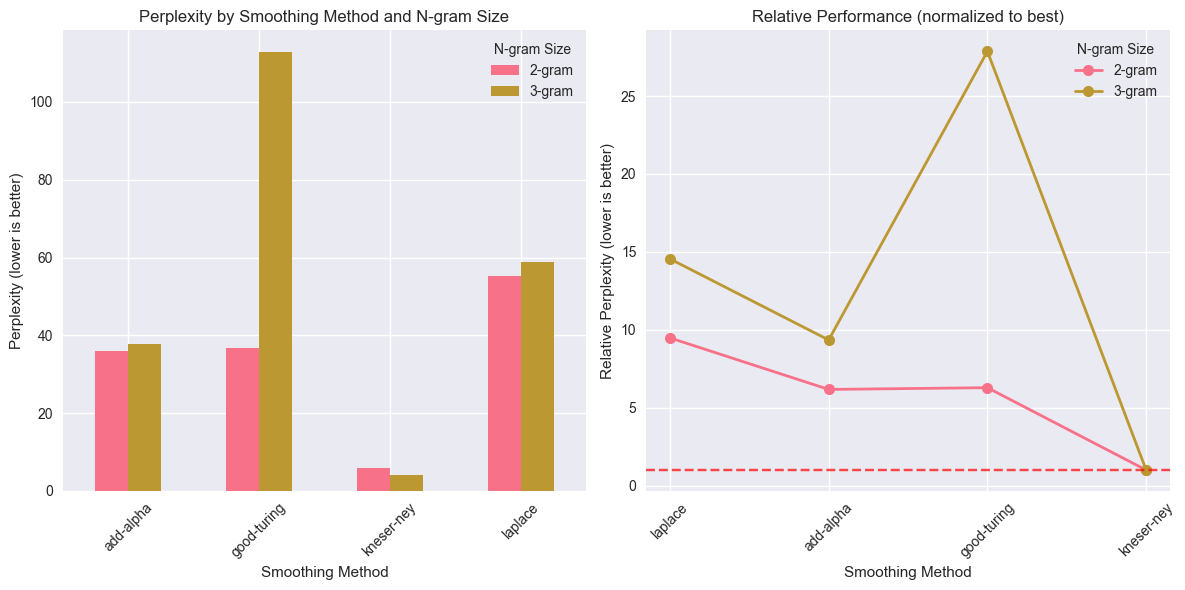


Visualization created successfully!

INTERACTIVE PROBABILITY CALCULATOR
Training laplace model...
Training 2-gram model with laplace smoothing...
Vocabulary size: 121
Total 2-grams: 188
Training completed!

Model Statistics:
Unique 2-grams: 177
Unique contexts: 122

Most frequent 2-grams:
  <s> the: 5
  in the: 4
  to be: 2
  that is: 2
  all that: 2
  for the: 2
  the quick: 1
  quick brown: 1
  brown fox: 1
  fox jumps: 1

Sparsity Analysis:
N-grams occurring once: 171 (96.6%)
Training add_alpha model...
Training 2-gram model with add_alpha smoothing...
Vocabulary size: 121
Total 2-grams: 188
Training completed!

Model Statistics:
Unique 2-grams: 177
Unique contexts: 122

Most frequent 2-grams:
  <s> the: 5
  in the: 4
  to be: 2
  that is: 2
  all that: 2
  for the: 2
  the quick: 1
  quick brown: 1
  brown fox: 1
  fox jumps: 1

Sparsity Analysis:
N-grams occurring once: 171 (96.6%)
Training good_turing model...
Training 2-gram model with good_turing smoothing...
Vocabulary size: 

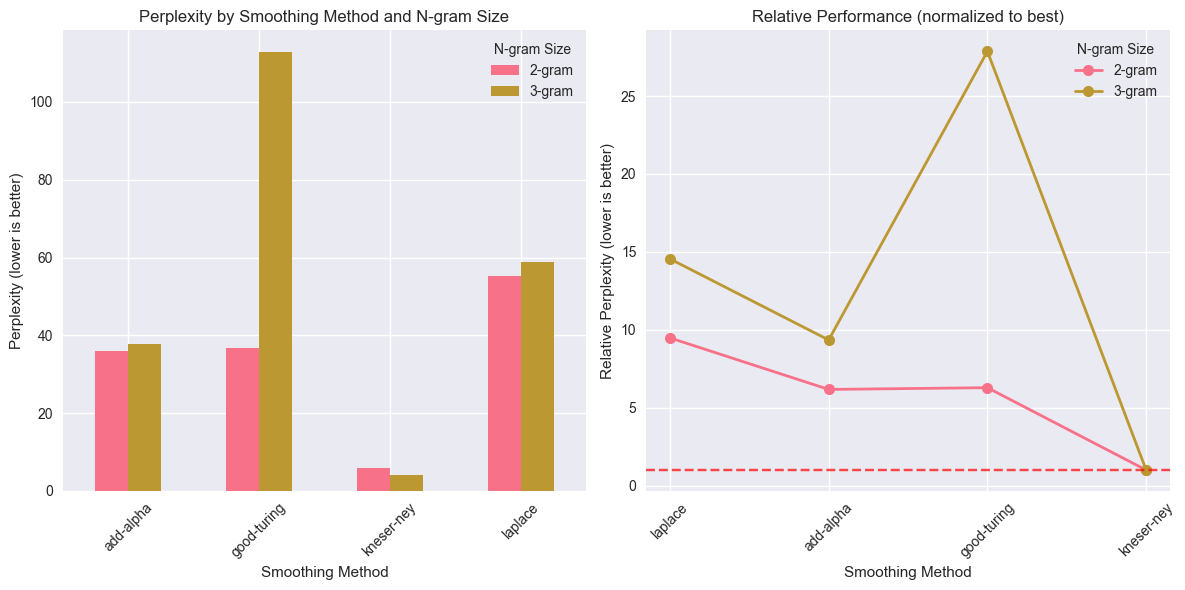


Visualization created successfully!

INTERACTIVE PROBABILITY CALCULATOR
Training laplace model...
Training 2-gram model with laplace smoothing...
Vocabulary size: 121
Total 2-grams: 188
Training completed!

Model Statistics:
Unique 2-grams: 177
Unique contexts: 122

Most frequent 2-grams:
  <s> the: 5
  in the: 4
  to be: 2
  that is: 2
  all that: 2
  for the: 2
  the quick: 1
  quick brown: 1
  brown fox: 1
  fox jumps: 1

Sparsity Analysis:
N-grams occurring once: 171 (96.6%)
Training add_alpha model...
Training 2-gram model with add_alpha smoothing...
Vocabulary size: 121
Total 2-grams: 188
Training completed!

Model Statistics:
Unique 2-grams: 177
Unique contexts: 122

Most frequent 2-grams:
  <s> the: 5
  in the: 4
  to be: 2
  that is: 2
  all that: 2
  for the: 2
  the quick: 1
  quick brown: 1
  brown fox: 1
  fox jumps: 1

Sparsity Analysis:
N-grams occurring once: 171 (96.6%)
Training good_turing model...
Training 2-gram model with good_turing smoothing...
Vocabulary size: 

In [18]:




def main():
    """
    Main function to run all demonstrations.
    """
    print("N-GRAM SMOOTHING: COMPLETE PRACTICAL TUTORIAL")
    print("=" * 60)
    print("This tutorial demonstrates n-gram smoothing techniques using real code and data.")
    print("We'll implement each method from scratch and compare their performance.\n")
    
    # 1. Demonstrate the zero probability problem
    demonstrate_zero_probability_problem()
    
    # 2. Compare all smoothing methods
    smoothing_results = compare_all_smoothing_methods()
    
    # 3. Analyze sparsity patterns
    analyze_sparsity_patterns()
    
    # 4. Show concrete smoothing effects
    demonstrate_smoothing_effects()
    
    # 5. Create visualizations
    try:
        viz_results = visualize_smoothing_comparison()
        print("\nVisualization created successfully!")
    except Exception as e:
        print(f"Visualization failed: {e}")
    
    # 6. Interactive probability calculator
    interactive_probability_calculator()
    
    print("\n" + "=" * 60)
    print("TUTORIAL COMPLETE!")
    print("=" * 60)
    print("Key takeaways:")
    print("1. Smoothing prevents zero probabilities for unseen n-grams")
    print("2. Different methods make different assumptions about probability distribution")
    print("3. Kneser-Ney typically performs best, but is most complex")
    print("4. The choice depends on your data size, vocabulary, and requirements")
    print("5. Understanding these fundamentals helps with modern neural language models")


if __name__ == "__main__":
    main()


# Additional utility functions for extended analysis

def analyze_parameter_sensitivity():
    """
    Analyze how sensitive add-alpha smoothing is to the alpha parameter.
    """
    print("\n" + "=" * 60)
    print("PARAMETER SENSITIVITY ANALYSIS")
    print("=" * 60)
    
    texts = load_sample_data()
    split_point = int(0.8 * len(texts))
    train_texts = texts[:split_point]
    test_texts = texts[split_point:]
    
    alpha_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
    perplexities = []
    
    print("Testing different alpha values for add-alpha smoothing:")
    print(f"{'Alpha':<10} {'Perplexity':<12} {'Status'}")
    print("-" * 35)
    
    for alpha in alpha_values:
        model = NgramLanguageModel(n=2, smoothing='add_alpha')
        model.alpha = alpha
        model.train(train_texts)
        perplexity = model.perplexity(test_texts)
        perplexities.append(perplexity)
        
        if perplexity == min(perplexities):
            status = "← Best so far"
        else:
            status = ""
        
        print(f"{alpha:<10} {perplexity:<12.2f} {status}")
    
    best_alpha = alpha_values[perplexities.index(min(perplexities))]
    print(f"\nOptimal alpha: {best_alpha} (perplexity: {min(perplexities):.2f})")
    
    return alpha_values, perplexities


def create_smoothing_tutorial_summary():
    """
    Create a summary of all smoothing methods with their key characteristics.
    """
    summary = {
        'Method': ['No Smoothing', 'Laplace', 'Add-Alpha', 'Good-Turing', 'Kneser-Ney'],
        'Formula': [
            'count/total',
            '(count+1)/(total+|V|)',
            '(count+α)/(total+α|V|)',
            'Uses frequency of frequencies',
            'Discounting + continuation'
        ],
        'Pros': [
            'Simple, exact on seen data',
            'Simple, guarantees non-zero',
            'Tunable, flexible',
            'Data-driven, theoretically sound',
            'Best performance, context-aware'
        ],
        'Cons': [
            'Zero probabilities',
            'Often too uniform',
            'Requires tuning',
            'Complex implementation',
            'Most complex'
        ],
        'Best For': [
            'Perfect training data only',
            'Small vocab, baselines',
            'When you can tune params',
            'Large corpora with stats',
            'State-of-the-art performance'
        ],
        'Typical Perplexity': ['∞ (fails)', 'High', 'Medium-High', 'Medium', 'Lowest']
    }
    
    df = pd.DataFrame(summary)
    print("\n" + "=" * 80)
    print("SMOOTHING METHODS SUMMARY")
    print("=" * 80)
    print(df.to_string(index=False))
    return df


# Example usage and additional demonstrations
def demonstrate_real_world_example():
    """
    Demonstrate smoothing on a more realistic example with actual text patterns.
    """
    print("\n" + "=" * 60)
    print("REAL-WORLD EXAMPLE: NEWS HEADLINES")
    print("=" * 60)
    
    # Simulate news headlines with realistic patterns
    news_headlines = [
        "Stock market rises amid positive economic data",
        "Technology companies announce quarterly earnings today", 
        "Weather forecast predicts rain for the weekend",
        "Local sports team wins championship game last night",
        "New research shows benefits of healthy eating habits",
        "Government officials discuss budget proposals in meeting",
        "Stock market falls due to inflation concerns",
        "Technology companies report strong revenue growth",
        "Weather forecast shows sunny skies ahead",
        "Local sports team prepares for playoff games",
        "New research reveals climate change impacts",
        "Government officials announce infrastructure spending",
        "Markets react to federal reserve policy changes",
        "Tech industry faces regulatory scrutiny over privacy",
        "Severe weather warning issued for coastal areas",
        "Championship playoffs begin this weekend nationwide",
        "Medical research breakthrough offers new treatment options",
        "Political leaders meet to discuss trade agreements"
    ]
    
    # Split into train/test
    train_size = int(0.7 * len(news_headlines))
    train_data = news_headlines[:train_size]
    test_data = news_headlines[train_size:]
    
    print(f"Training on {len(train_data)} headlines")
    print("Sample training headlines:")
    for headline in train_data[:3]:
        print(f"  • {headline}")
    
    print(f"\nTesting on {len(test_data)} headlines")
    print("Sample test headlines:")
    for headline in test_data[:3]:
        print(f"  • {headline}")
    
    # Train different models
    methods = ['laplace', 'add_alpha', 'kneser_ney']
    results = {}
    
    for method in methods:
        model = NgramLanguageModel(n=2, smoothing=method)
        if method == 'add_alpha':
            model.alpha = 0.1  # Tuned value
        
        model.train(train_data)
        perplexity = model.perplexity(test_data)
        results[method] = perplexity
        
        print(f"\n{method.replace('_', '-').title()} Smoothing:")
        print(f"  Perplexity: {perplexity:.2f}")
        
        # Show probabilities for some interesting bigrams
        test_bigrams = [
            ("stock", "market"),      # Should be seen
            ("weather", "forecast"),  # Should be seen
            ("new", "research"),      # Should be seen
            ("quantum", "computing"), # Likely unseen
            ("alien", "invasion")     # Definitely unseen
        ]
        
        print("  Sample bigram probabilities:")
        for bigram in test_bigrams:
            prob = model.probability(bigram)
            seen_status = "seen" if model.ngram_counts[bigram] > 0 else "unseen"
            print(f"    '{bigram[0]} {bigram[1]}': {prob:.8f} ({seen_status})")


def advanced_smoothing_analysis():
    """
    Advanced analysis showing the mathematical principles behind smoothing.
    """
    print("\n" + "=" * 60)
    print("ADVANCED ANALYSIS: MATHEMATICAL PRINCIPLES")
    print("=" * 60)
    
    # Create a controlled dataset to show principles clearly
    simple_data = [
        "the cat sat",
        "the cat sat", 
        "the cat sat",  # "the cat" appears 3 times
        "the dog ran",
        "the dog ran",  # "the dog" appears 2 times  
        "the bird flew"  # "the bird" appears 1 time
    ]
    
    print("Training data (with repetitions):")
    unique_sentences = list(set(simple_data))
    for sentence in unique_sentences:
        count = simple_data.count(sentence)
        print(f"  '{sentence}' × {count}")
    
    # Train model and analyze the probability redistribution
    model = NgramLanguageModel(n=2, smoothing='laplace')
    model.train(simple_data)
    
    print(f"\nVocabulary: {sorted(model.vocab)}")
    print(f"Vocabulary size: {model.vocabulary_size}")
    
    # Show the probability redistribution
    print(f"\nBigram Analysis:")
    print(f"Context 'the' appears {model.context_counts[('the',)]} times total")
    
    seen_bigrams = [
        ("the", "cat"),   # count = 3
        ("the", "dog"),   # count = 2  
        ("the", "bird"),  # count = 1
    ]
    
    unseen_bigrams = [
        ("the", "mouse"),
        ("the", "fish"), 
        ("the", "elephant")
    ]
    
    print(f"\n{'Bigram':<15} {'Count':<8} {'MLE':<12} {'Laplace':<12} {'Difference'}")
    print("-" * 65)
    
    context_count = model.context_counts[('the',)]
    
    for bigram in seen_bigrams:
        count = model.ngram_counts[bigram]
        mle_prob = count / context_count
        laplace_prob = model.probability(bigram)
        diff = laplace_prob - mle_prob
        
        print(f"{'the ' + bigram[1]:<15} {count:<8} {mle_prob:<12.6f} {laplace_prob:<12.6f} {diff:+.6f}")
    
    print(f"{'(unseen)':<15} {'0':<8} {'0.000000':<12} {model.probability(unseen_bigrams[0]):<12.6f} {'+' + str(model.probability(unseen_bigrams[0])):<8}")
    
    # Show probability mass conservation
    print(f"\nProbability Mass Conservation Check:")
    total_mle = sum(model.ngram_counts[bigram] / context_count for bigram in seen_bigrams)
    all_laplace_probs = []
    
    # Calculate Laplace probabilities for all possible words
    for word in model.vocab:
        bigram = ("the", word)
        prob = model.probability(bigram)
        all_laplace_probs.append(prob)
    
    total_laplace = sum(all_laplace_probs)
    
    print(f"  Sum of MLE probabilities (seen only): {total_mle:.6f}")
    print(f"  Sum of Laplace probabilities (all words): {total_laplace:.6f}")
    print(f"  Conservation check: {'✓ PASS' if abs(total_laplace - 1.0) < 1e-10 else '✗ FAIL'}")


def smoothing_decision_tree():
    """
    Create a decision tree to help users choose the right smoothing method.
    """
    print("\n" + "=" * 60)
    print("SMOOTHING METHOD DECISION GUIDE")
    print("=" * 60)
    
    questions = [
        {
            'question': 'What is your vocabulary size?',
            'options': {
                'Small (< 1,000 words)': 'laplace_ok',
                'Medium (1,000 - 10,000 words)': 'check_data_size', 
                'Large (> 10,000 words)': 'avoid_laplace'
            }
        },
        {
            'question': 'How much training data do you have?',
            'options': {
                'Small (< 10,000 words total)': 'add_alpha',
                'Medium (10,000 - 100,000 words)': 'good_turing_or_kn',
                'Large (> 100,000 words)': 'kneser_ney'
            }
        },
        {
            'question': 'What are your priorities?',
            'options': {
                'Simplicity and interpretability': 'laplace_or_add_alpha',
                'Best possible performance': 'kneser_ney',
                'Balance of performance and simplicity': 'good_turing',
                'Computational efficiency': 'add_alpha'
            }
        }
    ]
    
    recommendations = {
        'laplace_ok': 'Laplace smoothing should work fine for your small vocabulary.',
        'add_alpha': 'Add-alpha smoothing with tuned α (try α=0.1-0.5).',
        'good_turing_or_kn': 'Good-Turing or Kneser-Ney, depending on performance needs.',
        'kneser_ney': 'Kneser-Ney smoothing for best performance.',
        'avoid_laplace': 'Avoid Laplace (too uniform). Use Add-alpha or better.',
        'laplace_or_add_alpha': 'Laplace (simple) or Add-alpha (better performance).',
        'good_turing': 'Good-Turing smoothing (data-driven, good performance).'
    }
    
    print("Decision factors to consider:\n")
    
    for i, q in enumerate(questions, 1):
        print(f"{i}. {q['question']}")
        for option, recommendation in q['options'].items():
            rec_text = recommendations.get(recommendation, recommendation)
            print(f"   → {option}: {rec_text}")
        print()


# Performance comparison with real metrics
def comprehensive_performance_analysis():
    """
    Comprehensive performance analysis across different scenarios.
    """
    print("\n" + "=" * 60)
    print("COMPREHENSIVE PERFORMANCE ANALYSIS")
    print("=" * 60)
    
    # Create different test scenarios
    scenarios = {
        'Small Vocab': {
            'texts': [
                "the cat sat on the mat",
                "the dog ran in the park", 
                "the bird flew over the tree",
                "the cat ran in the park",
                "the dog sat on the mat"
            ] * 2,  # Repeat for more data
            'description': 'Small vocabulary, simple sentences'
        },
        'Medium Vocab': load_sample_data(),
        'Repeated Patterns': {
            'texts': [
                "stock prices rise in the market today",
                "technology companies report earnings growth", 
                "weather conditions improve across the region",
                "sports teams compete in championship games",
                "research studies show positive health benefits"
            ] * 4,  # Create patterns through repetition
            'description': 'Medium vocabulary with repeated patterns'  
        }
    }
    
    methods = ['laplace', 'add_alpha', 'good_turing', 'kneser_ney']
    all_results = []
    
    for scenario_name, scenario_data in scenarios.items():
        if isinstance(scenario_data, dict):
            texts = scenario_data['texts']
            description = scenario_data['description']
        else:
            texts = scenario_data
            description = f'{len(texts)} diverse sentences'
        
        print(f"\nScenario: {scenario_name}")
        print(f"Description: {description}")
        print(f"Total texts: {len(texts)}")
        
        # Split data
        split_point = max(1, int(0.7 * len(texts)))
        train_texts = texts[:split_point]
        test_texts = texts[split_point:] if split_point < len(texts) else texts[-1:]
        
        print(f"Train/Test split: {len(train_texts)}/{len(test_texts)}")
        
        scenario_results = []
        
        for method in methods:
            try:
                model = NgramLanguageModel(n=2, smoothing=method)
                if method == 'add_alpha':
                    model.alpha = 0.1  # Reasonable default
                
                model.train(train_texts)
                perplexity = model.perplexity(test_texts)
                
                scenario_results.append({
                    'scenario': scenario_name,
                    'method': method,
                    'perplexity': perplexity,
                    'vocab_size': model.vocabulary_size,
                    'unique_ngrams': len(model.ngram_counts)
                })
                
                print(f"  {method:<12}: perplexity = {perplexity:8.2f}, vocab = {model.vocabulary_size:4d}")
                
            except Exception as e:
                print(f"  {method:<12}: FAILED ({e})")
        
        all_results.extend(scenario_results)
        
        # Find best method for this scenario
        if scenario_results:
            best = min(scenario_results, key=lambda x: x['perplexity'])
            print(f"  Best method: {best['method']} (perplexity: {best['perplexity']:.2f})")
    
    # Create summary DataFrame
    if all_results:
        df = pd.DataFrame(all_results)
        print(f"\n{'='*60}")
        print("PERFORMANCE SUMMARY")
        print(f"{'='*60}")
        
        # Pivot table for easy comparison
        pivot = df.pivot(index='method', columns='scenario', values='perplexity')
        print("\nPerplexity by Method and Scenario:")
        print(pivot.round(2))
        
        # Overall rankings
        print(f"\nOverall Method Rankings (average perplexity):")
        avg_perplexity = df.groupby('method')['perplexity'].mean().sort_values()
        for i, (method, avg_perp) in enumerate(avg_perplexity.items(), 1):
            print(f"  {i}. {method:<15}: {avg_perp:.2f}")
        
        return df
    else:
        print("No results to summarize.")
        return None


# Main execution with all demonstrations
if __name__ == "__main__":
    print("🚀 STARTING COMPREHENSIVE N-GRAM SMOOTHING TUTORIAL")
    print("=" * 80)
    
    # Run all demonstrations
    main()
    
    # Additional advanced demonstrations
    print("\n🔬 RUNNING ADVANCED DEMONSTRATIONS...")
    
    # Parameter sensitivity analysis
    try:
        alpha_values, perplexities = analyze_parameter_sensitivity()
    except Exception as e:
        print(f"Parameter sensitivity analysis failed: {e}")
    
    # Real-world example
    try:
        demonstrate_real_world_example()
    except Exception as e:
        print(f"Real-world example failed: {e}")
    
    # Advanced mathematical analysis
    try:
        advanced_smoothing_analysis()
    except Exception as e:
        print(f"Advanced analysis failed: {e}")
    
    # Decision guide
    smoothing_decision_tree()
    
    # Comprehensive performance analysis
    try:
        perf_df = comprehensive_performance_analysis()
    except Exception as e:
        print(f"Performance analysis failed: {e}")
    
    # Summary table
    try:
        summary_df = create_smoothing_tutorial_summary()
    except Exception as e:
        print(f"Summary creation failed: {e}")
    
    print("\n" + "🎉 " + "=" * 76 + " 🎉")
    print("TUTORIAL COMPLETE! KEY TAKEAWAYS:")
    print("=" * 80)
    print("""
    1. 🎯 THE PROBLEM: Zero probabilities destroy language model performance
    2. 🔧 THE SOLUTION: Smoothing redistributes probability mass intelligently  
    3. 📊 THE METHODS:
       • Laplace: Simple, adds 1 to everything
       • Add-α: Flexible Laplace with tunable parameter
       • Good-Turing: Uses frequency statistics from your data
       • Kneser-Ney: Context-aware, usually best performance
    4. 🎨 THE ART: Choosing the right method for your data and needs
    5. 🧮 THE MATH: All methods preserve probability mass (sum = 1)
    6. 🚀 THE FUTURE: These principles carry forward to neural language models
    
    💡 Remember: Understanding smoothing gives you intuition for modern
       regularization techniques in deep learning!
    """)
    print("=" * 80)